
===== PERFORMANCE COMPARISON =====
                             Final    Profit  Sharpe  MaxDD  Trades
Period      Strategy                                               
03feb-18feb MACD         992032.00  -7968.00   -0.01  -0.01   16317
            RSI          998932.25  -1067.75   -0.00  -0.01    3718
            Stochastic   995367.50  -4632.50   -0.01  -0.01    1011
            Combined     999608.75   -391.25   -0.00  -0.00    1348
            Buy&Hold    1031855.25  31855.25    0.01  -0.02       1
31mar-15apr MACD        1002442.50   2442.50    0.00  -0.03   15923
            RSI          987211.75 -12788.25   -0.00  -0.03    3971
            Stochastic  1010147.00  10147.00    0.00  -0.02    1267
            Combined    1004937.25   4937.25    0.00  -0.02    1322
            Buy&Hold     975614.00 -24386.00   -0.00  -0.16       1
full-period MACD         956567.00 -43433.00   -0.00  -0.06   69055
            RSI         1016051.50  16051.50    0.00  -0.03   16613
            

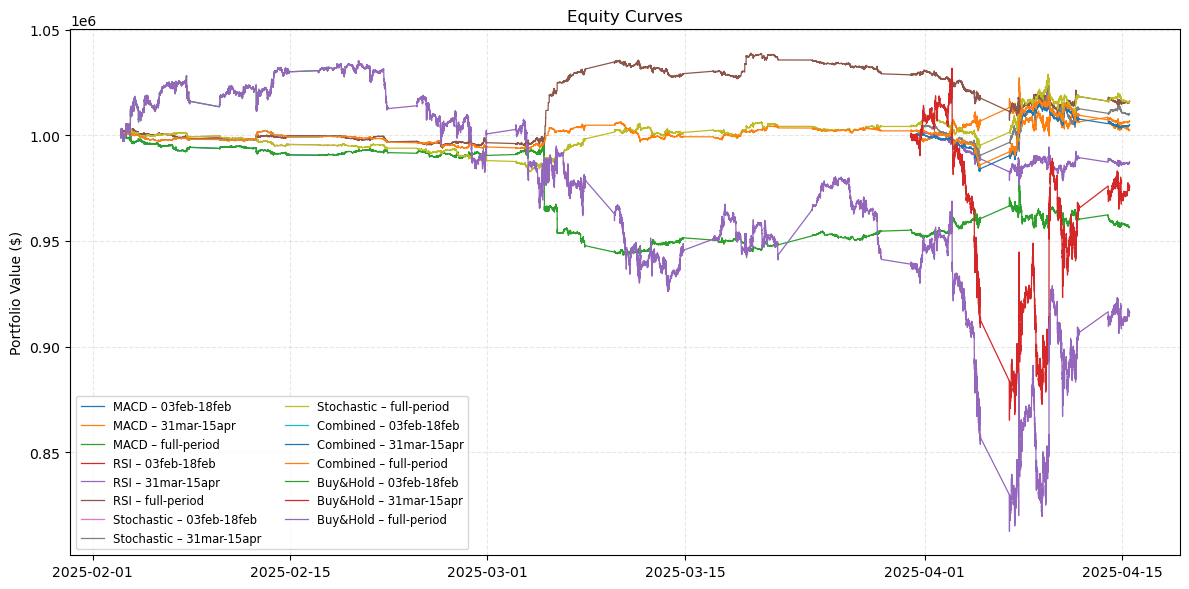

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from typing import Dict

# ─── CONFIG ─────────────────────────────────────────────────────
PERIODS = {
    "03feb-18feb": ("2025-02-03", "2025-02-18"),
    "31mar-15apr": ("2025-03-31", "2025-04-15"),
    "full-period": (None, None),  # unfiltered
}

STRATS: Dict[str, str | None] = {
    "MACD":      "Signal_MACD",
    "RSI":       "Signal_RSI",
    "Stochastic":"Signal_Stoch",
    "Combined":  "Signal_Comb",
    "Buy&Hold":  None,
}

# ─── LOAD AND PREP DATA ─────────────────────────────────────────
def load_data():
    df = pd.read_csv("combined_all_three.csv", parse_dates=["timestamp"])
    df = df.set_index("timestamp")
    return df[["open", "high", "low", "close", "volume"]]

def add_indicators(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # ATR
    df["TR"] = pd.concat([
        df.high - df.low,
        (df.high - df.close.shift()).abs(),
        (df.low - df.close.shift()).abs()
    ], axis=1).max(axis=1)
    df["ATR"] = df["TR"].rolling(14).mean()

    # MACD
    s, l, sig = 3, 15, 5
    df["MACD"] = df.close.ewm(span=s, adjust=False).mean() - df.close.ewm(span=l, adjust=False).mean()
    df["MACD_signal"] = df.MACD.ewm(span=sig, adjust=False).mean()
    df["Signal_MACD"] = np.where(df.MACD > df.MACD_signal, 1, -1)

    # RSI
    delta = df.close.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    rs = gain.rolling(14).mean() / loss.rolling(14).mean()
    df["RSI"] = 100 - 100 / (1 + rs)
    df["Signal_RSI"] = np.select([df.RSI < 30, df.RSI > 70], [1, -1], 0)

    # Stochastic
    ll = df.low.rolling(14).min()
    hh = df.high.rolling(14).max()
    df["%K"] = (df.close - ll) / (hh - ll) * 100
    df["%D"] = df["%K"].rolling(3).mean()
    prev_k, prev_d = df["%K"].shift(), df["%D"].shift()
    buy = (prev_k < prev_d) & (df["%K"] > df["%D"]) & (df["%K"] < 20)
    sell = (prev_k > prev_d) & (df["%K"] < df["%D"]) & (df["%K"] > 80)
    df["Signal_Stoch"] = 0
    df.loc[buy, "Signal_Stoch"] = 1
    df.loc[sell, "Signal_Stoch"] = -1

    # Combined
    df["Signal_Comb"] = 0
    df.loc[(df.Signal_MACD == 1) & (df.Signal_RSI == 1), "Signal_Comb"] = 1
    df.loc[(df.Signal_MACD == -1) & (df.Signal_RSI == -1), "Signal_Comb"] = -1

    return df

# ─── BACKTEST LOGIC ─────────────────────────────────────────────
def _qty(price, cash, pct=0.2, cap=500): return min(cap, int((cash * pct) / price))

def _backtest(df: pd.DataFrame, sig_col: str, cash0: float = 1_000_000):
    cash, pos = cash0, 0
    fee, slm, tpm = 0., 1.5, 3.0
    entry = sl = tp = None
    port = []

    for price, sig, atr in zip(df.close, df[sig_col], df.ATR):
        if pos > 0 and (price >= tp or price <= sl):
            cash += pos * price - fee
            pos = 0
        elif pos < 0 and (price <= tp or price >= sl):
            cash -= price * -pos + fee
            pos = 0

        if pos == 0 and sig and not np.isnan(atr):
            qty = _qty(price, cash)
            if qty:
                if sig == 1:
                    cash -= qty * price + fee
                    pos = qty
                    entry, sl, tp = price, price - slm * atr, price + tpm * atr
                elif sig == -1:
                    cash += qty * price - fee
                    pos = -qty
                    entry, sl, tp = price, price + slm * atr, price - tpm * atr
        port.append(cash if pos == 0 else cash + pos * price)
    return port

def _hold(df: pd.DataFrame, cash0: float = 1_000_000):
    p0 = df.close.iloc[0]
    qty = int(cash0 / p0)
    cash = cash0 - qty * p0
    return (cash + qty * df.close).tolist()

def _mdd(arr):
    arr = np.array(arr)
    roll_max = np.maximum.accumulate(arr)
    drawdowns = (arr - roll_max) / roll_max
    return float(drawdowns.min())

def _sharpe(arr):
    r = pd.Series(arr).pct_change().dropna()
    return float(r.mean() / r.std()) if r.std() else np.nan

# ─── RUN COMPARISON ─────────────────────────────────────────────
def run_comparison():
    global full_df
    full_df = load_data()
    results, plots = [], {}

    for label, (start, end) in PERIODS.items():
        df = full_df.loc[start:end] if start else full_df.copy()
        df = add_indicators(df)

        for strat, sig in STRATS.items():
            port = _hold(df) if sig is None else _backtest(df, sig)
            results.append(dict(
                Period=label, Strategy=strat,
                Final=port[-1], Profit=port[-1] - 1_000_000,
                Sharpe=_sharpe(port), MaxDD=_mdd(port),
                Trades=(np.array(df[sig]) != 0).sum() if sig else 1
            ))
            plots.setdefault(strat, {})[label] = port

    df_res = pd.DataFrame(results).set_index(["Period", "Strategy"])
    print("\n===== PERFORMANCE COMPARISON =====")
    print(df_res.round(2).to_string())
    return df_res, plots

# ─── PLOT ───────────────────────────────────────────────────────
def plot_equity_curves(plots: dict):
    fig, ax = plt.subplots(figsize=(12, 6))
    for strat, period_dict in plots.items():
        for label, port in period_dict.items():
            df_period = full_df.loc[PERIODS[label][0]:PERIODS[label][1]] if PERIODS[label][0] else full_df.copy()
            dates = df_period.index[:len(port)]
            ax.plot(dates, port, label=f"{strat} – {label}", linewidth=0.9)

    ax.set_title("Equity Curves")
    ax.set_ylabel("Portfolio Value ($)")
    ax.grid(True, linestyle="--", alpha=0.3)
    ax.legend(ncol=2, fontsize="small")
    plt.tight_layout()
    plt.show()

# ─── EXECUTE ────────────────────────────────────────────────────
if __name__ == "__main__":
    df_result, equity_curves = run_comparison()
    plot_equity_curves(equity_curves)


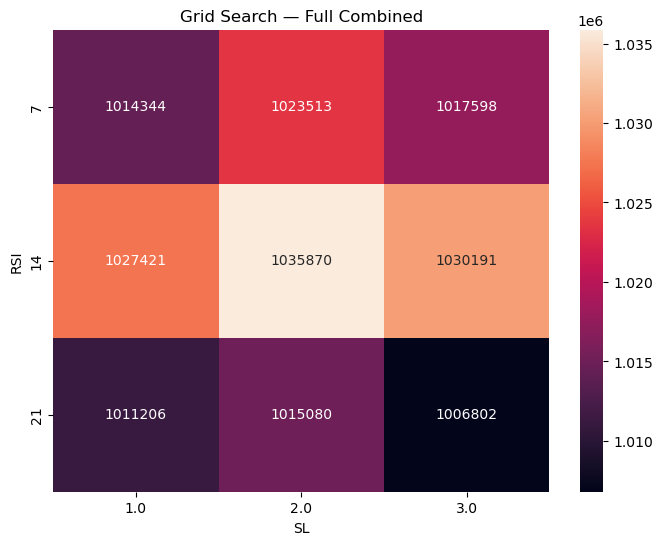

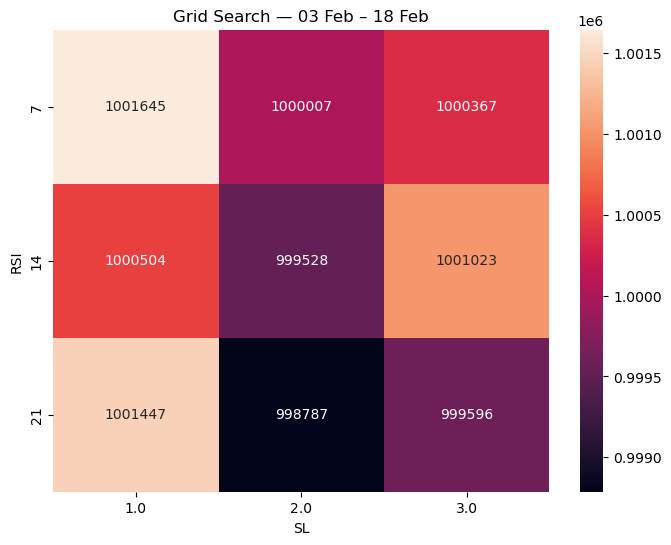

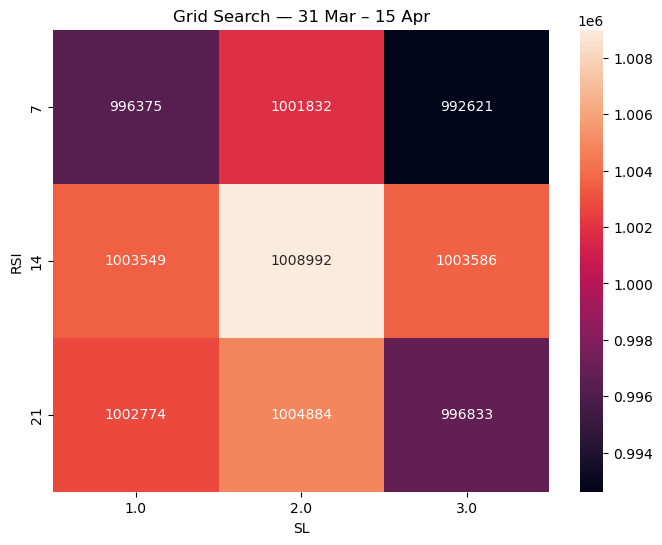

100%|██████████| 30/30 [00:00<00:00, 52.66trial/s, best loss: -1095755.25]
Best Bayesian Parameters: {'OB': 65.0, 'OS': 20.0, 'RSI': 13.0, 'SL': 2.524206666712028, 'TP': 2.45868200796796}
Best parameters exported to 'best_rsi_parameters.csv'.


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import warnings

warnings.filterwarnings("ignore")

# ─── Strategy Backtest Engine ────────────────────────────────────────
class RSIBacktester:
    def __init__(self, df, cash=1_000_000):
        self.df = df
        self.cash = cash

    def add_indicators(self, rsi_period):
        delta = self.df['close'].diff()
        gain = delta.clip(lower=0)
        loss = -delta.clip(upper=0)
        rs = gain.rolling(rsi_period).mean() / loss.rolling(rsi_period).mean()
        self.df['RSI'] = 100 - 100 / (1 + rs)

        tr = pd.concat([
            self.df['high'] - self.df['low'],
            (self.df['high'] - self.df['close'].shift()).abs(),
            (self.df['low'] - self.df['close'].shift()).abs()
        ], axis=1).max(axis=1)
        self.df['ATR'] = tr.rolling(14).mean()

    def generate_signals(self, overbought, oversold):
        self.df['Signal'] = np.select([self.df['RSI'] < oversold, self.df['RSI'] > overbought], [1, -1], 0)

    def backtest(self, sl_atr, tp_atr):
        cash, pos = self.cash, 0
        equity = []
        stop = target = None

        for price, atr, sig in zip(self.df['close'], self.df['ATR'], self.df['Signal']):
            if pos > 0 and (price >= target or price <= stop):
                cash += pos * price
                pos = 0
            elif pos < 0 and (price <= target or price >= stop):
                cash -= -pos * price
                pos = 0

            if pos == 0 and sig != 0 and not np.isnan(atr):
                qty = int((cash * 0.2) / price)
                if sig == 1:
                    cash -= qty * price
                    pos = qty
                    stop = price - sl_atr * atr
                    target = price + tp_atr * atr
                else:
                    cash += qty * price
                    pos = -qty
                    stop = price + sl_atr * atr
                    target = price - tp_atr * atr

            equity.append(cash if pos == 0 else cash + pos * price)
        return equity

# ─── Optimizer (Grid & Bayesian) ─────────────────────────────────────
class Optimizer:
    def __init__(self, df_dict):
        self.df_dict = df_dict
        self.best_params = {}

    def grid_search(self, rsi_periods, overbought_list, oversold_list, sl_list, tp_list):
        for period_name, df in self.df_dict.items():
            results = []
            for rsi_p in rsi_periods:
                for ob in overbought_list:
                    for os in oversold_list:
                        for sl in sl_list:
                            for tp in tp_list:
                                backtester = RSIBacktester(df.copy())
                                backtester.add_indicators(rsi_p)
                                backtester.generate_signals(ob, os)
                                equity = backtester.backtest(sl, tp)
                                results.append({
                                    'RSI': rsi_p, 'OB': ob, 'OS': os,
                                    'SL': sl, 'TP': tp,
                                    'Final': equity[-1]
                                })
            df_res = pd.DataFrame(results)
            best = df_res.sort_values('Final', ascending=False).iloc[0]
            self.best_params[period_name] = best
            df_pivot = df_res.pivot_table(values='Final', index='RSI', columns='SL')
            plt.figure(figsize=(8,6))
            sns.heatmap(df_pivot, annot=True, fmt=".0f")
            plt.title(f"Grid Search — {period_name}")
            plt.show()

    def bayesian_optimization(self, max_evals=30):
        def objective(params):
            rsi_p = int(params['RSI'])
            ob = int(params['OB'])
            os = int(params['OS'])
            sl = params['SL']
            tp = params['TP']

            backtester = RSIBacktester(self.df_dict['Full Combined'].copy())
            backtester.add_indicators(rsi_p)
            backtester.generate_signals(ob, os)
            equity = backtester.backtest(sl, tp)
            return {'loss': -equity[-1], 'status': STATUS_OK}

        space = {
            'RSI': hp.quniform('RSI', 5, 21, 1),
            'OB': hp.quniform('OB', 60, 80, 1),
            'OS': hp.quniform('OS', 20, 40, 1),
            'SL': hp.uniform('SL', 1.0, 3.0),
            'TP': hp.uniform('TP', 2.0, 6.0),
        }

        trials = Trials()
        best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=max_evals, trials=trials)
        self.best_params['Bayesian'] = best
        print(f"Best Bayesian Parameters: {best}")

# ─── Loader & Runner ───────────────────────────────────────────────
def load_data(file):
    df = pd.read_csv(file, parse_dates=['timestamp']).set_index('timestamp')
    return df[['open', 'high', 'low', 'close', 'volume']]

def main():
    path = '/Users/oscarolsen/Downloads/combined_all_three.csv'
    df = load_data(path)

    periods = {
        'Full Combined': df.copy(),
        '03 Feb – 18 Feb': df.loc['2025-02-03':'2025-02-18'],
        '31 Mar – 15 Apr': df.loc['2025-03-31':'2025-04-15'],
    }

    opt = Optimizer(periods)
    opt.grid_search(rsi_periods=[7, 14, 21],
                    overbought_list=[60, 70, 80],
                    oversold_list=[20, 30, 40],
                    sl_list=[1.0, 2.0, 3.0],
                    tp_list=[3.0, 4.0, 6.0])

    opt.bayesian_optimization(max_evals=30)

    # Export best parameters
    pd.DataFrame(opt.best_params).T.to_csv('best_rsi_parameters.csv')
    print("Best parameters exported to 'best_rsi_parameters.csv'.")

if __name__ == "__main__":
    main()


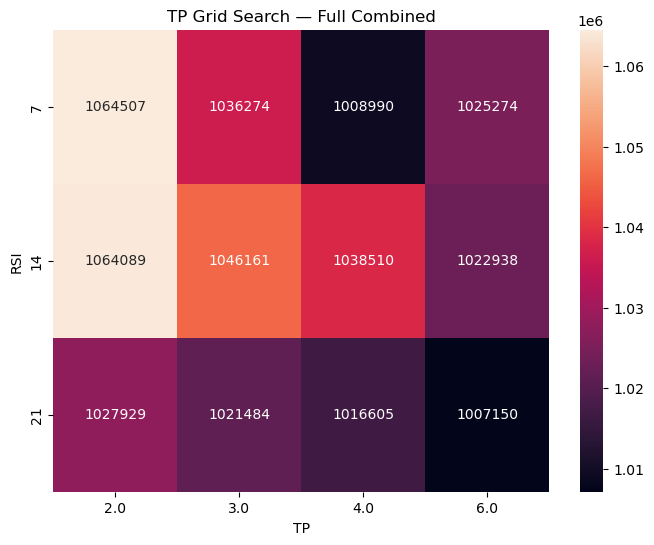

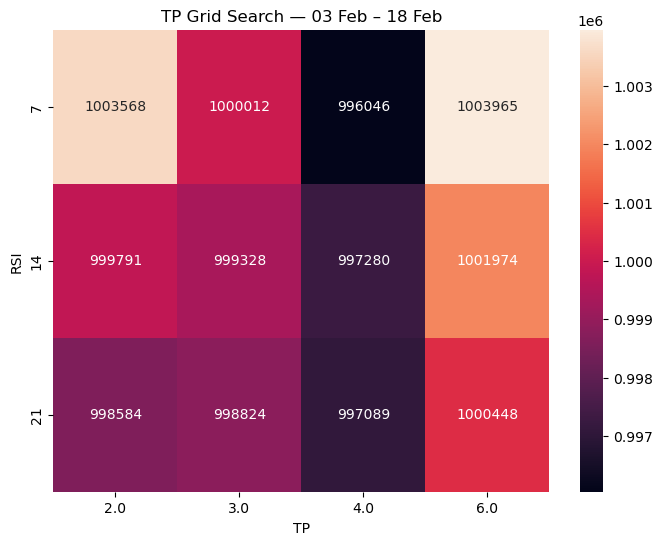

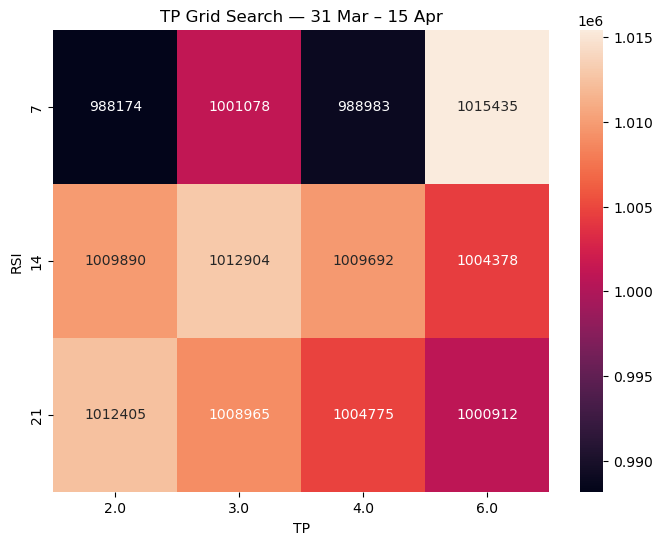

100%|██████████| 30/30 [00:00<00:00, 50.43trial/s, best loss: -1103954.75]
Best TP Parameters (Bayesian): {'OB': 62.0, 'OS': 34.0, 'RSI': 14.0, 'TP': 3.3895959206459105}
Best TP parameters exported to 'best_tp_parameters.csv'.


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import warnings

warnings.filterwarnings("ignore")

# ─── Strategy Backtest Engine ────────────────────────────────────────
class RSIBacktester:
    def __init__(self, df, cash=1_000_000):
        self.df = df
        self.cash = cash

    def add_indicators(self, rsi_period):
        delta = self.df['close'].diff()
        gain = delta.clip(lower=0)
        loss = -delta.clip(upper=0)
        rs = gain.rolling(rsi_period).mean() / loss.rolling(rsi_period).mean()
        self.df['RSI'] = 100 - 100 / (1 + rs)

        tr = pd.concat([
            self.df['high'] - self.df['low'],
            (self.df['high'] - self.df['close'].shift()).abs(),
            (self.df['low'] - self.df['close'].shift()).abs()
        ], axis=1).max(axis=1)
        self.df['ATR'] = tr.rolling(14).mean()

    def generate_signals(self, overbought, oversold):
        self.df['Signal'] = np.select([self.df['RSI'] < oversold, self.df['RSI'] > overbought], [1, -1], 0)

    def backtest(self, tp_atr, sl_atr=2.0):
        cash, pos = self.cash, 0
        equity = []
        stop = target = None

        for price, atr, sig in zip(self.df['close'], self.df['ATR'], self.df['Signal']):
            if pos > 0 and (price >= target or price <= stop):
                cash += pos * price
                pos = 0
            elif pos < 0 and (price <= target or price >= stop):
                cash -= -pos * price
                pos = 0

            if pos == 0 and sig != 0 and not np.isnan(atr):
                qty = int((cash * 0.2) / price)
                if sig == 1:
                    cash -= qty * price
                    pos = qty
                    stop = price - sl_atr * atr
                    target = price + tp_atr * atr
                else:
                    cash += qty * price
                    pos = -qty
                    stop = price + sl_atr * atr
                    target = price - tp_atr * atr

            equity.append(cash if pos == 0 else cash + pos * price)
        return equity

# ─── Optimizer (TP Only) ─────────────────────────────────────────────
class TPOptimizer:
    def __init__(self, df_dict, sl_atr=2.0):
        self.df_dict = df_dict
        self.sl_atr = sl_atr
        self.best_params = {}

    def grid_search(self, rsi_periods, overbought_list, oversold_list, tp_list):
        for period_name, df in self.df_dict.items():
            results = []
            for rsi_p in rsi_periods:
                for ob in overbought_list:
                    for os in oversold_list:
                        for tp in tp_list:
                            backtester = RSIBacktester(df.copy())
                            backtester.add_indicators(rsi_p)
                            backtester.generate_signals(ob, os)
                            equity = backtester.backtest(tp_atr=tp, sl_atr=self.sl_atr)
                            results.append({
                                'RSI': rsi_p, 'OB': ob, 'OS': os,
                                'TP': tp, 'Final': equity[-1]
                            })
            df_res = pd.DataFrame(results)
            best = df_res.sort_values('Final', ascending=False).iloc[0]
            self.best_params[period_name] = best
            df_pivot = df_res.pivot_table(values='Final', index='RSI', columns='TP')
            plt.figure(figsize=(8, 6))
            sns.heatmap(df_pivot, annot=True, fmt=".0f")
            plt.title(f"TP Grid Search — {period_name}")
            plt.show()

    def bayesian_optimization(self, max_evals=30):
        def objective(params):
            rsi_p = int(params['RSI'])
            ob = int(params['OB'])
            os = int(params['OS'])
            tp = params['TP']

            backtester = RSIBacktester(self.df_dict['Full Combined'].copy())
            backtester.add_indicators(rsi_p)
            backtester.generate_signals(ob, os)
            equity = backtester.backtest(tp_atr=tp, sl_atr=self.sl_atr)
            return {'loss': -equity[-1], 'status': STATUS_OK}

        space = {
            'RSI': hp.quniform('RSI', 5, 21, 1),
            'OB': hp.quniform('OB', 60, 80, 1),
            'OS': hp.quniform('OS', 20, 40, 1),
            'TP': hp.uniform('TP', 2.0, 6.0),
        }

        trials = Trials()
        best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=max_evals, trials=trials)
        self.best_params['Bayesian'] = best
        print(f"Best TP Parameters (Bayesian): {best}")

# ─── Loader & Runner ───────────────────────────────────────────────
def load_data(file):
    df = pd.read_csv(file, parse_dates=['timestamp']).set_index('timestamp')
    return df[['open', 'high', 'low', 'close', 'volume']]

# ─── Run directly ──────────────────────────────────────────────────
df = load_data("combined_all_three.csv")
periods = {
    'Full Combined': df.copy(),
    '03 Feb – 18 Feb': df.loc['2025-02-03':'2025-02-18'],
    '31 Mar – 15 Apr': df.loc['2025-03-31':'2025-04-15'],
}

opt = TPOptimizer(periods, sl_atr=2.0)

# Grid Search on TP only
opt.grid_search(
    rsi_periods=[7, 14, 21],
    overbought_list=[60, 70, 80],
    oversold_list=[20, 30, 40],
    tp_list=[2.0, 3.0, 4.0, 6.0]
)

# Bayesian Optimization on TP only
opt.bayesian_optimization(max_evals=30)

# Export results
pd.DataFrame(opt.best_params).T.to_csv('best_tp_parameters.csv')
print("Best TP parameters exported to 'best_tp_parameters.csv'.")


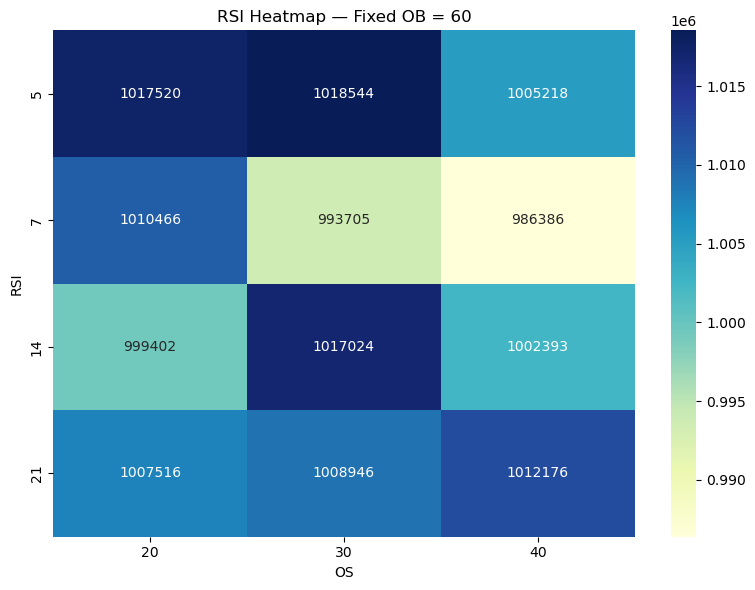

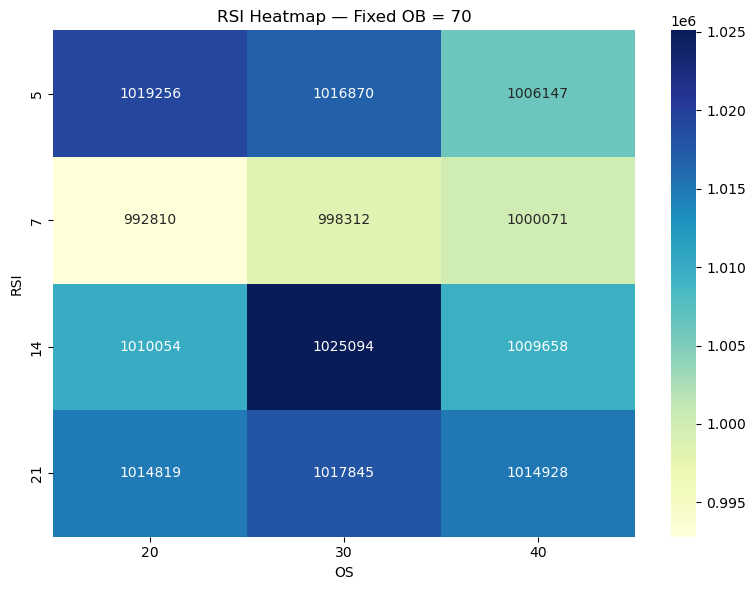

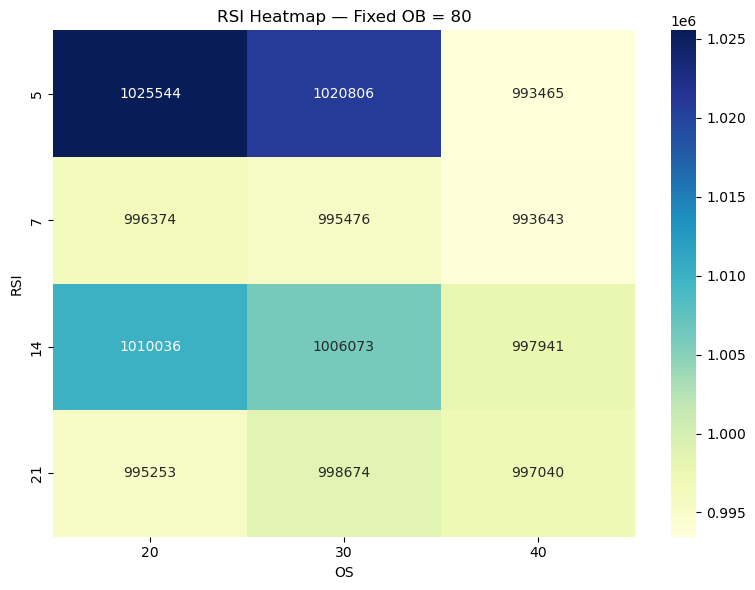

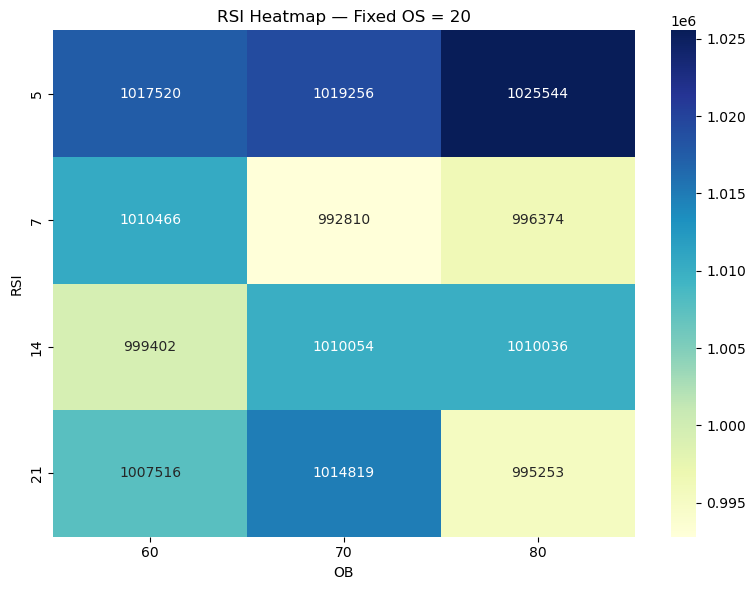

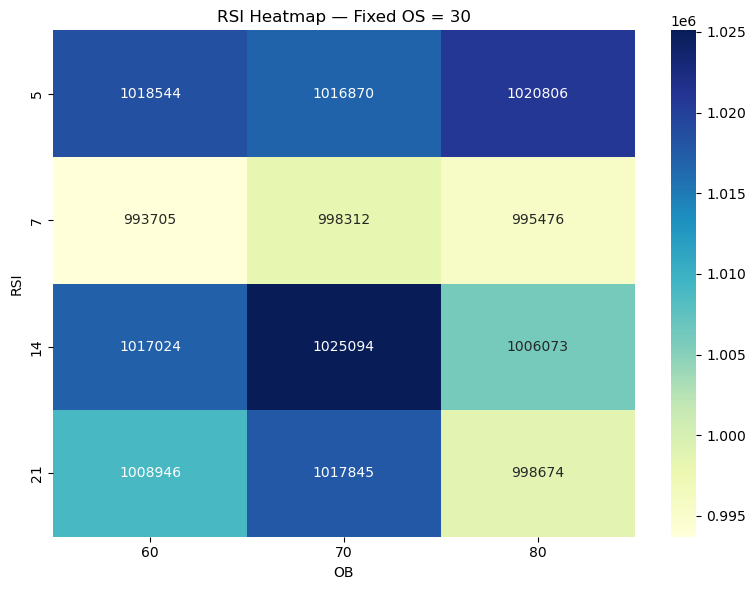

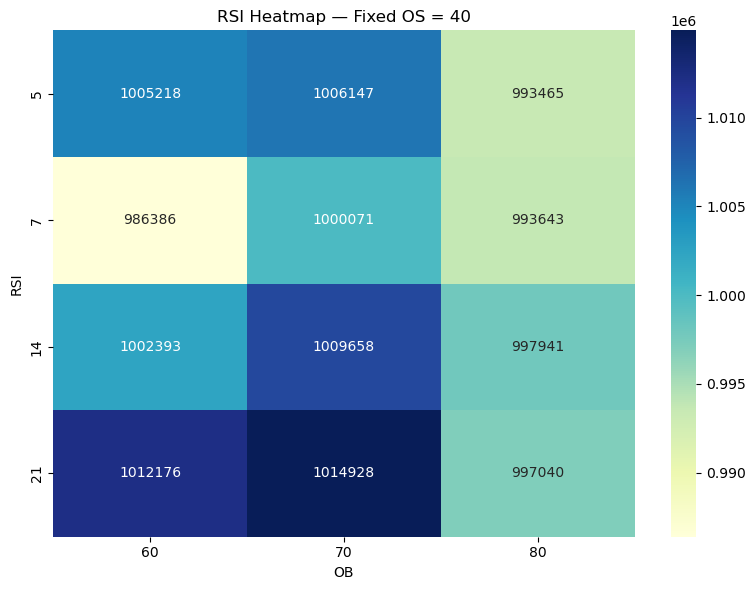

,RSI,OB,OS,Final,Trades
0,5,80,20,1025543.75,1131
1,14,70,30,1025094.25,1056
2,5,80,30,1020805.50,1177
3,5,70,20,1019256.00,1151
4,5,60,30,1018543.50,1178
5,21,70,30,1017845.00,777
6,5,60,20,1017520.00,1175
7,14,60,30,1017023.75,1142
8,5,70,30,1016870.25,1171
9,21,70,40,1014928.50,983


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Constants
VOL_WIN, VOL_MED_WIN = 80, 1440
THR_HIGH, THR_LOW = 1.1, 0.9
CASH0, RISK_PCT = 1_000_000, 0.20
MAX_QTY, FEE = 500, 0

# Parameter grids
rsi_periods = [5, 7, 14, 21]
overbought_list = [60, 70, 80]
oversold_list = [20, 30, 40]

# Load your DataFrame (assumes it's already loaded as `df`)
df = df.copy()

# Precompute indicators
df['VOL_S'] = df['volume'].rolling(VOL_WIN).mean()
df['VOL_L'] = df['volume'].rolling(VOL_MED_WIN).mean()
df['VOL_RATIO'] = df['VOL_S'] / df['VOL_L']

tr1 = df['high'] - df['low']
tr2 = (df['high'] - df['close'].shift()).abs()
tr3 = (df['low'] - df['close'].shift()).abs()
tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
df['ATR'] = tr.rolling(14).mean()

results = []

for rsi_p in rsi_periods:
    delta = df['close'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    rs = gain.rolling(rsi_p).mean() / loss.rolling(rsi_p).mean()
    df['RSI'] = 100 - 100 / (1 + rs)

    for ob in overbought_list:
        for os in oversold_list:
            df['Signal'] = np.select(
                [df['RSI'] < os, df['RSI'] > ob],
                [1, -1], 0
            )

            cash, pos = CASH0, 0
            stop = target = None
            equity = []
            num_trades = 0

            for _, row in df.iterrows():
                price = row['close']
                atr = row['ATR']
                sig = row['Signal']
                vol_ratio = row['VOL_RATIO']

                if pos > 0 and (price >= target or price <= stop):
                    cash += pos * price
                    pos = 0
                elif pos < 0 and (price <= target or price >= stop):
                    cash -= -pos * price
                    pos = 0

                if pos == 0 and sig != 0 and not np.isnan(atr) and not np.isnan(vol_ratio):
                    if vol_ratio > THR_HIGH or vol_ratio < THR_LOW:
                        qty = int((cash * RISK_PCT) / price)
                        qty = min(qty, MAX_QTY)

                        if sig == 1:
                            cash -= qty * price
                            pos = qty
                            stop = price - 2.0 * atr
                            target = price + 3.0 * atr
                            num_trades += 1
                        elif sig == -1:
                            cash += qty * price
                            pos = -qty
                            stop = price + 2.0 * atr
                            target = price - 3.0 * atr
                            num_trades += 1

                equity.append(cash if pos == 0 else cash + pos * price)

            if equity:
                results.append({
                    'RSI': rsi_p,
                    'OB': ob,
                    'OS': os,
                    'Final': equity[-1],
                    'Trades': num_trades
                })

# Create DataFrame of results
df_res = pd.DataFrame(results)

# Plot heatmaps for fixed OB or OS
for fixed in ['OB', 'OS']:
    for val in sorted(df_res[fixed].unique()):
        pivot = df_res[df_res[fixed] == val].pivot(
            index='RSI',
            columns='OB' if fixed == 'OS' else 'OS',
            values='Final'
        )
        plt.figure(figsize=(8, 6))
        sns.heatmap(pivot, annot=True, fmt=".0f", cmap="YlGnBu")
        plt.title(f"RSI Heatmap — Fixed {fixed} = {val}")
        plt.xlabel('OB' if fixed == 'OS' else 'OS')
        plt.ylabel('RSI')
        plt.tight_layout()
        plt.show()

# Summary table
summary = df_res.sort_values('Final', ascending=False).reset_index(drop=True)
display(summary.head(10))

# Optional: export to CSV
#summary.to_csv("rsi_heatmap_summary.csv", index=False)
#print("Summary exported to 'rsi_heatmap_summary.csv'")


,Fast,Slow,Signal,Final,Trades,Momentum %,Swing %
0,8,26,6,995076.50,1272,31.1,68.9
1,12,20,12,991111.75,1279,32.2,67.8
2,8,32,6,990787.25,1263,31.6,68.4
3,16,20,9,989961.25,1268,32.0,68.0
4,16,20,12,989074.00,1283,32.1,67.9
5,8,20,12,988841.50,1263,32.1,67.9
6,16,26,9,988224.25,1291,31.9,68.1
7,12,26,12,988162.00,1289,31.7,68.3
8,8,26,9,988112.00,1255,31.9,68.1
9,8,20,6,987671.00,1291,31.7,68.3


MACD summary exported to 'macd_summary.csv'.


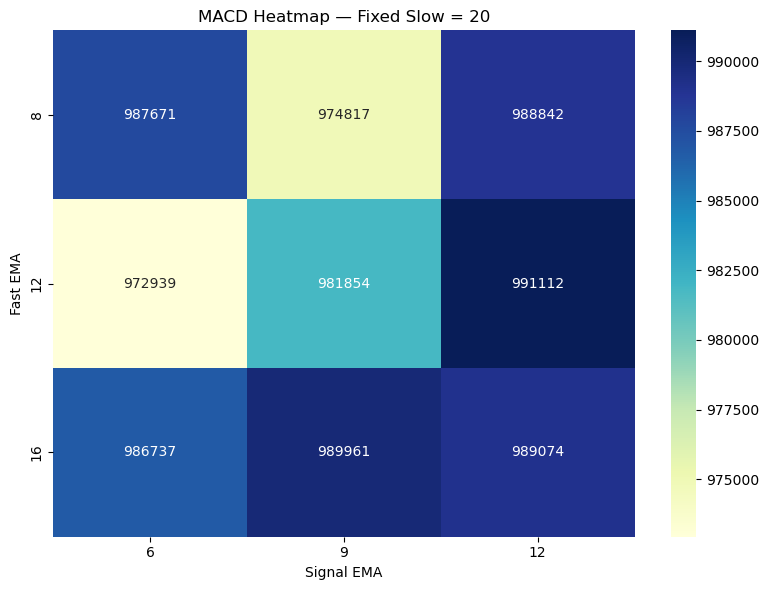

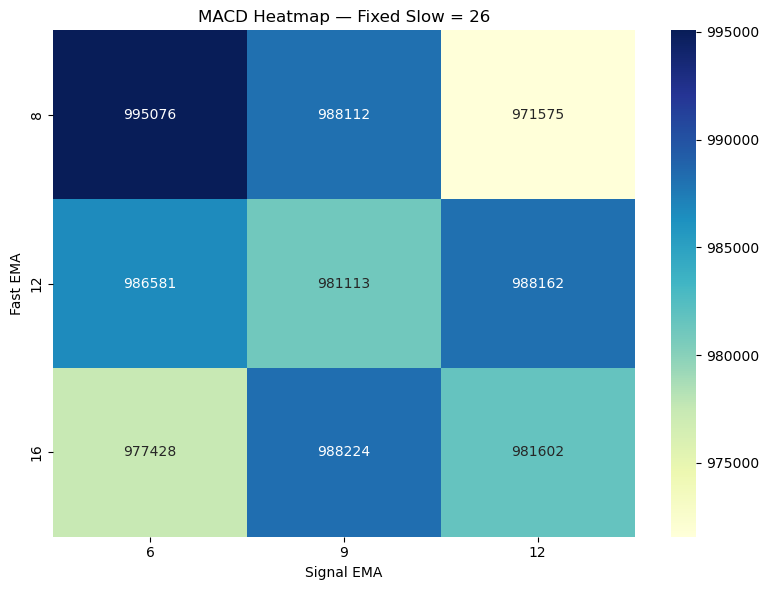

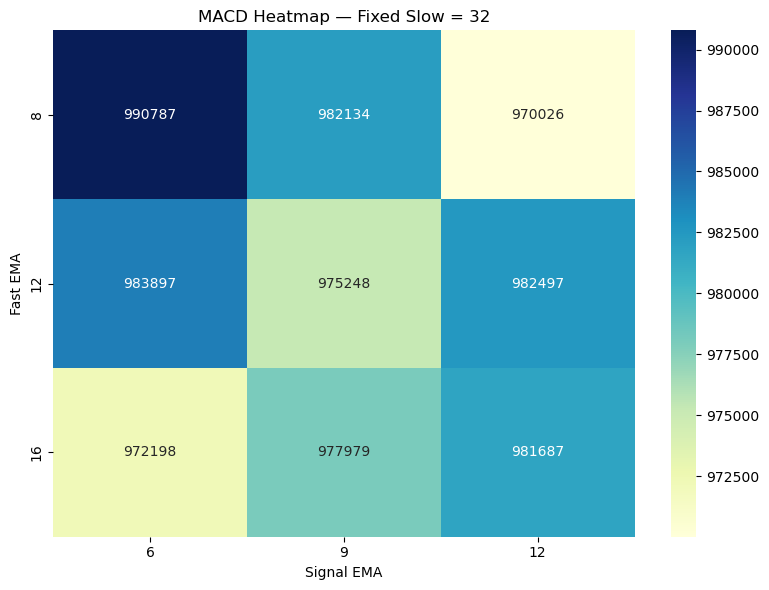

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# MACD parameter grid
fast_list = [8, 12, 16]
slow_list = [20, 26, 32]
signal_list = [6, 9, 12]

# Constants
VOL_WIN, VOL_MED_WIN = 80, 1440
THR_HIGH, THR_LOW = 1.1, 0.9
CASH0, RISK_PCT = 1_000_000, 0.20
MAX_QTY = 500

# Prepare data
df_macd = df.copy()
df_macd['VOL_S'] = df_macd['volume'].rolling(VOL_WIN).mean()
df_macd['VOL_L'] = df_macd['volume'].rolling(VOL_MED_WIN).mean()
df_macd['VOL_RATIO'] = df_macd['VOL_S'] / df_macd['VOL_L']

tr1 = df_macd['high'] - df_macd['low']
tr2 = (df_macd['high'] - df_macd['close'].shift()).abs()
tr3 = (df_macd['low'] - df_macd['close'].shift()).abs()
tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
df_macd['ATR'] = tr.rolling(14).mean()

results = []

for fast in fast_list:
    for slow in slow_list:
        if slow <= fast:
            continue
        for sig_p in signal_list:
            df_macd['EMA_fast'] = df_macd['close'].ewm(span=fast).mean()
            df_macd['EMA_slow'] = df_macd['close'].ewm(span=slow).mean()
            df_macd['MACD'] = df_macd['EMA_fast'] - df_macd['EMA_slow']
            df_macd['Signal'] = df_macd['MACD'].ewm(span=sig_p).mean()

            df_macd['Cross'] = np.where(
                df_macd['MACD'] > df_macd['Signal'], 1,
                np.where(df_macd['MACD'] < df_macd['Signal'], -1, 0)
            )

            cash, pos = CASH0, 0
            stop = target = None
            equity = []
            num_trades = 0
            momentum_trades = 0
            swing_trades = 0

            for _, row in df_macd.iterrows():
                price = row['close']
                atr = row['ATR']
                sig = row['Cross']
                vol_ratio = row['VOL_RATIO']

                if pos > 0 and (price >= target or price <= stop):
                    cash += pos * price
                    pos = 0
                elif pos < 0 and (price <= target or price >= stop):
                    cash -= -pos * price
                    pos = 0

                if pos == 0 and sig != 0 and not np.isnan(atr) and not np.isnan(vol_ratio):
                    if vol_ratio > THR_HIGH or vol_ratio < THR_LOW:
                        qty = int((cash * RISK_PCT) / price)
                        qty = min(qty, MAX_QTY)

                        if sig == 1:
                            cash -= qty * price
                            pos = qty
                            stop = price - 2.0 * atr
                            target = price + 3.0 * atr
                            num_trades += 1
                            if vol_ratio > THR_HIGH:
                                momentum_trades += 1
                            elif vol_ratio < THR_LOW:
                                swing_trades += 1
                        elif sig == -1:
                            cash += qty * price
                            pos = -qty
                            stop = price + 2.0 * atr
                            target = price - 3.0 * atr
                            num_trades += 1
                            if vol_ratio > THR_HIGH:
                                momentum_trades += 1
                            elif vol_ratio < THR_LOW:
                                swing_trades += 1

                equity.append(cash if pos == 0 else cash + pos * price)

            if equity:
                results.append({
                    'Fast': fast,
                    'Slow': slow,
                    'Signal': sig_p,
                    'Final': equity[-1],
                    'Trades': num_trades,
                    'Momentum %': round(momentum_trades / num_trades * 100, 1) if num_trades > 0 else 0,
                    'Swing %': round(swing_trades / num_trades * 100, 1) if num_trades > 0 else 0
                })

# Create result DataFrame
df_macd_res = pd.DataFrame(results)

# Summary table
macd_summary = df_macd_res.sort_values('Final', ascending=False).reset_index(drop=True)
display(macd_summary.head(10))

# Optional: export
macd_summary.to_csv("macd_summary.csv", index=False)
print("MACD summary exported to 'macd_summary.csv'.")

# Heatmap: Fast vs Signal at fixed Slow
for fixed_slow in sorted(df_macd_res['Slow'].unique()):
    pivot = df_macd_res[df_macd_res['Slow'] == fixed_slow].pivot(
        index='Fast', columns='Signal', values='Final'
    )
    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot, annot=True, fmt=".0f", cmap="YlGnBu")
    plt.title(f"MACD Heatmap — Fixed Slow = {fixed_slow}")
    plt.xlabel('Signal EMA')
    plt.ylabel('Fast EMA')
    plt.tight_layout()
    plt.show()


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ─── Stochastic Parameter Grid ────────────────────────────────────────
k_periods = [5, 10, 14, 21]
d_periods = [3, 5, 7]
overbought_list = [70, 80, 90]
oversold_list = [10, 20, 30]

# ─── Constants ────────────────────────────────────────────────────────
VOL_WIN, VOL_MED_WIN = 80, 1440
THR_HIGH, THR_LOW = 1.1, 0.9
CASH0, RISK_PCT = 1_000_000, 0.20
MAX_QTY = 500

# ─── Prepare Data ─────────────────────────────────────────────────────
df_stoch = df.copy()
df_stoch['VOL_S'] = df_stoch['volume'].rolling(VOL_WIN).mean()
df_stoch['VOL_L'] = df_stoch['volume'].rolling(VOL_MED_WIN).mean()
df_stoch['VOL_RATIO'] = df_stoch['VOL_S'] / df_stoch['VOL_L']

tr1 = df_stoch['high'] - df_stoch['low']
tr2 = (df_stoch['high'] - df_stoch['close'].shift()).abs()
tr3 = (df_stoch['low'] - df_stoch['close'].shift()).abs()
tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
df_stoch['ATR'] = tr.rolling(14).mean()

results = []

# ─── Optimization Loop ────────────────────────────────────────────────
for k in k_periods:
    lowest_low = df_stoch['low'].rolling(k).min()
    highest_high = df_stoch['high'].rolling(k).max()
    df_stoch['%K'] = 100 * (df_stoch['close'] - lowest_low) / (highest_high - lowest_low)

    for d in d_periods:
        df_stoch['%D'] = df_stoch['%K'].rolling(d).mean()

        for ob in overbought_list:
            for os in oversold_list:
                df_stoch['Signal'] = 0
                # Long: %K crosses above %D below OS
                long_entry = (df_stoch['%K'].shift(1) < df_stoch['%D'].shift(1)) & \
                             (df_stoch['%K'] > df_stoch['%D']) & \
                             (df_stoch['%K'] < os)
                # Short: %K crosses below %D above OB
                short_entry = (df_stoch['%K'].shift(1) > df_stoch['%D'].shift(1)) & \
                              (df_stoch['%K'] < df_stoch['%D']) & \
                              (df_stoch['%K'] > ob)
                df_stoch.loc[long_entry, 'Signal'] = 1
                df_stoch.loc[short_entry, 'Signal'] = -1

                cash, pos = CASH0, 0
                stop = target = None
                equity = []
                num_trades = 0
                momentum_trades = 0
                swing_trades = 0

                for _, row in df_stoch.iterrows():
                    price = row['close']
                    atr = row['ATR']
                    sig = row['Signal']
                    vol_ratio = row['VOL_RATIO']

                    if pos > 0 and (price >= target or price <= stop):
                        cash += pos * price
                        pos = 0
                    elif pos < 0 and (price <= target or price >= stop):
                        cash -= -pos * price
                        pos = 0

                    if pos == 0 and sig != 0 and not np.isnan(atr) and not np.isnan(vol_ratio):
                        if vol_ratio > THR_HIGH or vol_ratio < THR_LOW:
                            qty = int((cash * RISK_PCT) / price)
                            qty = min(qty, MAX_QTY)

                            if sig == 1:
                                cash -= qty * price
                                pos = qty
                                stop = price - 2.0 * atr
                                target = price + 3.0 * atr
                                num_trades += 1
                                if vol_ratio > THR_HIGH:
                                    momentum_trades += 1
                                elif vol_ratio < THR_LOW:
                                    swing_trades += 1
                            elif sig == -1:
                                cash += qty * price
                                pos = -qty
                                stop = price + 2.0 * atr
                                target = price - 3.0 * atr
                                num_trades += 1
                                if vol_ratio > THR_HIGH:
                                    momentum_trades += 1
                                elif vol_ratio < THR_LOW:
                                    swing_trades += 1

                    equity.append(cash if pos == 0 else cash + pos * price)

                if equity:
                    results.append({
                        'K': k,
                        'D': d,
                        'OB': ob,
                        'OS': os,
                        'Final': equity[-1],
                        'Trades': num_trades,
                        'Momentum %': round(momentum_trades / num_trades * 100, 1) if num_trades > 0 else 0,
                        'Swing %': round(swing_trades / num_trades * 100, 1) if num_trades > 0 else 0
                    })

# ─── Results and Visuals ─────────────────────────────────────────────
df_stoch_res = pd.DataFrame(results)
summary = df_stoch_res.sort_values('Final', ascending=False).reset_index(drop=True)
display(summary.head(10))

# Optional export
# summary.to_csv("stochastic_summary.csv", index=False)
# print("Stochastic summary exported to 'stochastic_summary.csv'.")


# Heatmaps for fixed D and OB values
for fixed_d in sorted(df_stoch_res['D'].unique()):
    for fixed_ob in sorted(df_stoch_res['OB'].unique()):
        subset = df_stoch_res[(df_stoch_res['D'] == fixed_d) & (df_stoch_res['OB'] == fixed_ob)]
        pivot = subset.pivot(index='K', columns='OS', values='Final')
        plt.figure(figsize=(8, 6))
        sns.heatmap(pivot, annot=True, fmt=".0f", cmap="YlGnBu")
        plt.title(f"Stochastic Heatmap — D={fixed_d}, OB={fixed_ob}")
        plt.xlabel('Oversold (OS)')
        plt.ylabel('K Period')
        plt.tight_layout()
        plt.show()



KeyboardInterrupt: 

In [ ]:
# Load full dataset
df_all = pd.read_csv("combined_all_three.csv", parse_dates=['timestamp']).set_index('timestamp')
df_all = df_all[['open', 'high', 'low', 'close', 'volume']]

# Define time windows
periods = {
    "Full Period": df_all.copy(),
    "03 Feb – 18 Feb": df_all.loc["2025-02-03":"2025-02-18"].copy(),
    "31 Mar – 15 Apr": df_all.loc["2025-03-31":"2025-04-15"].copy(),
}


In [ ]:
def compute_buy_and_hold(df, cash=1_000_000):
    buy_price = df['close'].iloc[0]
    sell_price = df['close'].iloc[-1]
    shares = cash / buy_price
    return shares * sell_price


In [ ]:
rsi_params = {'rsi_period': 14, 'ob': 70, 'os': 30}
macd_params = {'fast': 8, 'slow': 26, 'signal': 6}
stoch_params = {'k': 14, 'd': 5, 'ob': 70, 'os': 20}


In [28]:
results = []


# ─── RSI Strategy ─────────────────────────────────────
class RSIBacktester:
    def __init__(self, df, cash=1_000_000):
        self.df = df
        self.cash = cash

    def add_indicators(self, rsi_period):
        delta = self.df['close'].diff()
        gain = delta.clip(lower=0)
        loss = -delta.clip(upper=0)
        rs = gain.rolling(rsi_period).mean() / loss.rolling(rsi_period).mean()
        self.df['RSI'] = 100 - 100 / (1 + rs)

        tr = pd.concat([
            self.df['high'] - self.df['low'],
            (self.df['high'] - self.df['close'].shift()).abs(),
            (self.df['low'] - self.df['close'].shift()).abs()
        ], axis=1).max(axis=1)
        self.df['ATR'] = tr.rolling(14).mean()

        self.df['VOL_S'] = self.df['volume'].rolling(80).mean()
        self.df['VOL_L'] = self.df['volume'].rolling(1440).mean()
        self.df['VOL_RATIO'] = self.df['VOL_S'] / self.df['VOL_L']

    def generate_signals(self, ob, os):
        self.df['Signal'] = np.select([self.df['RSI'] < os, self.df['RSI'] > ob], [1, -1], 0)

    def backtest(self, tp_atr=3.0, sl_atr=2.0):
        cash, pos = self.cash, 0
        stop = target = None
        equity = []

        for _, row in self.df.iterrows():
            price, sig, atr, vr = row['close'], row['Signal'], row['ATR'], row['VOL_RATIO']

            if pos > 0 and (price >= target or price <= stop):
                cash += pos * price
                pos = 0
            elif pos < 0 and (price <= target or price >= stop):
                cash -= -pos * price
                pos = 0

            if pos == 0 and sig != 0 and not np.isnan(atr) and (vr > 1.1 or vr < 0.9):
                qty = int((cash * 0.2) / price)
                if sig == 1:
                    cash -= qty * price
                    pos = qty
                    stop = price - sl_atr * atr
                    target = price + tp_atr * atr
                elif sig == -1:
                    cash += qty * price
                    pos = -qty
                    stop = price + sl_atr * atr
                    target = price - tp_atr * atr

            equity.append(cash if pos == 0 else cash + pos * price)

        return equity

# ─── MACD Strategy ─────────────────────────────────────
class MACDBacktester:
    def __init__(self, df, cash=1_000_000):
        self.df = df
        self.cash = cash

    def add_indicators(self, fast, slow, signal):
        self.df['EMA_fast'] = self.df['close'].ewm(span=fast).mean()
        self.df['EMA_slow'] = self.df['close'].ewm(span=slow).mean()
        self.df['MACD'] = self.df['EMA_fast'] - self.df['EMA_slow']
        self.df['SignalLine'] = self.df['MACD'].ewm(span=signal).mean()

        self.df['VOL_S'] = self.df['volume'].rolling(80).mean()
        self.df['VOL_L'] = self.df['volume'].rolling(1440).mean()
        self.df['VOL_RATIO'] = self.df['VOL_S'] / self.df['VOL_L']

        tr = pd.concat([
            self.df['high'] - self.df['low'],
            (self.df['high'] - self.df['close'].shift()).abs(),
            (self.df['low'] - self.df['close'].shift()).abs()
        ], axis=1).max(axis=1)
        self.df['ATR'] = tr.rolling(14).mean()

    def generate_signals(self):
        self.df['Signal'] = np.select(
            [self.df['MACD'] > self.df['SignalLine'], self.df['MACD'] < self.df['SignalLine']],
            [1, -1],
            0
        )

    def backtest(self, tp_atr=3.0, sl_atr=2.0):
        cash, pos = self.cash, 0
        stop = target = None
        equity = []

        for _, row in self.df.iterrows():
            price, sig, atr, vr = row['close'], row['Signal'], row['ATR'], row['VOL_RATIO']

            if pos > 0 and (price >= target or price <= stop):
                cash += pos * price
                pos = 0
            elif pos < 0 and (price <= target or price >= stop):
                cash -= -pos * price
                pos = 0

            if pos == 0 and sig != 0 and not np.isnan(atr) and (vr > 1.1 or vr < 0.9):
                qty = int((cash * 0.2) / price)
                if sig == 1:
                    cash -= qty * price
                    pos = qty
                    stop = price - sl_atr * atr
                    target = price + tp_atr * atr
                elif sig == -1:
                    cash += qty * price
                    pos = -qty
                    stop = price + sl_atr * atr
                    target = price - tp_atr * atr

            equity.append(cash if pos == 0 else cash + pos * price)

        return equity

# ─── Stochastic Strategy ───────────────────────────────
class StochBacktester:
    def __init__(self, df, cash=1_000_000):
        self.df = df
        self.cash = cash

    def add_indicators(self, k_period, d_period):
        low_k = self.df['low'].rolling(k_period).min()
        high_k = self.df['high'].rolling(k_period).max()
        self.df['%K'] = 100 * (self.df['close'] - low_k) / (high_k - low_k)
        self.df['%D'] = self.df['%K'].rolling(d_period).mean()

        self.df['VOL_S'] = self.df['volume'].rolling(80).mean()
        self.df['VOL_L'] = self.df['volume'].rolling(1440).mean()
        self.df['VOL_RATIO'] = self.df['VOL_S'] / self.df['VOL_L']

        tr = pd.concat([
            self.df['high'] - self.df['low'],
            (self.df['high'] - self.df['close'].shift()).abs(),
            (self.df['low'] - self.df['close'].shift()).abs()
        ], axis=1).max(axis=1)
        self.df['ATR'] = tr.rolling(14).mean()

    def generate_signals(self, ob, os):
        self.df['Signal'] = np.select(
            [self.df['%K'] < os, self.df['%K'] > ob],
            [1, -1],
            0
        )

    def backtest(self, tp_atr=3.0, sl_atr=2.0):
        cash, pos = self.cash, 0
        stop = target = None
        equity = []

        for _, row in self.df.iterrows():
            price, sig, atr, vr = row['close'], row['Signal'], row['ATR'], row['VOL_RATIO']

            if pos > 0 and (price >= target or price <= stop):
                cash += pos * price
                pos = 0
            elif pos < 0 and (price <= target or price >= stop):
                cash -= -pos * price
                pos = 0

            if pos == 0 and sig != 0 and not np.isnan(atr) and (vr > 1.1 or vr < 0.9):
                qty = int((cash * 0.2) / price)
                if sig == 1:
                    cash -= qty * price
                    pos = qty
                    stop = price - sl_atr * atr
                    target = price + tp_atr * atr
                elif sig == -1:
                    cash += qty * price
                    pos = -qty
                    stop = price + sl_atr * atr
                    target = price - tp_atr * atr

            equity.append(cash if pos == 0 else cash + pos * price)

        return equity


for label, df in periods.items():
    # Buy and Hold
    bh = compute_buy_and_hold(df)

    # RSI strategy
    rsi_bt = RSIBacktester(df.copy())
    rsi_bt.add_indicators(rsi_params['rsi_period'])
    rsi_bt.generate_signals(rsi_params['ob'], rsi_params['os'])
    rsi_eq = rsi_bt.backtest(tp_atr=3.0, sl_atr=2.0)

    # MACD strategy
    macd_bt = MACDBacktester(df.copy())
    macd_bt.add_indicators(macd_params['fast'], macd_params['slow'], macd_params['signal'])
    macd_bt.generate_signals()
    macd_eq = macd_bt.backtest(tp_atr=3.0, sl_atr=2.0)

    # Stochastic strategy
    stoch_bt = StochBacktester(df.copy())
    stoch_bt.add_indicators(stoch_params['k'], stoch_params['d'])
    stoch_bt.generate_signals(stoch_params['ob'], stoch_params['os'])
    stoch_eq = stoch_bt.backtest(tp_atr=3.0, sl_atr=2.0)

    results.append({
        'Period': label,
        'Buy & Hold': round(bh, 2),
        'RSI': round(rsi_eq[-1], 2),
        'MACD': round(macd_eq[-1], 2),
        'Stochastic': round(stoch_eq[-1], 2),
    })

# Convert to DataFrame
import pandas as pd
pd.DataFrame(results)


,Period,Buy & Hold,RSI,MACD,Stochastic
0,Full Combined,915686.93,1025094.25,995076.50,1002757.75
1,03 Feb – 18 Feb,1032037.29,998510.25,994185.00,1000348.75
2,31 Mar – 15 Apr,975487.56,1026886.50,1000368.75,1002598.25


<Figure size 1000x600 with 0 Axes>

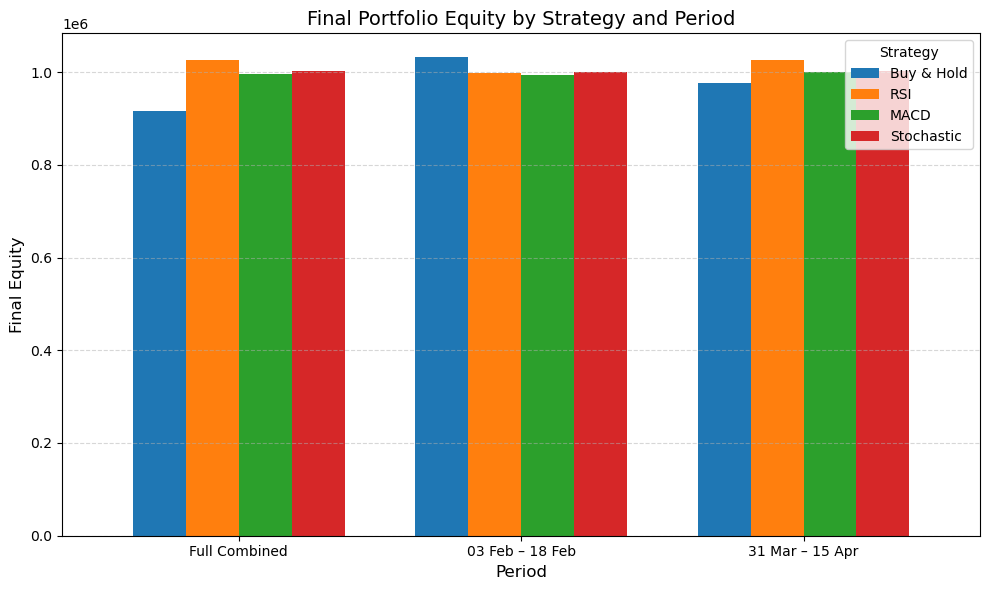

In [30]:
import matplotlib.pyplot as plt

import pandas as pd

df_results = pd.DataFrame(results)


# Assuming you have a DataFrame called `df_results` like this:
# | Period | Buy & Hold | RSI | MACD | Stochastic |

df_results.set_index("Period", inplace=True)

# Plotting
plt.figure(figsize=(10, 6))
df_results.plot(kind='bar', figsize=(10, 6), width=0.75)

plt.title("Final Portfolio Equity by Strategy and Period", fontsize=14)
plt.ylabel("Final Equity", fontsize=12)
plt.xlabel("Period", fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title="Strategy")
plt.tight_layout()
plt.show()
